In [17]:
from CartPole import *
import numpy as np
import random

In [45]:
def kernel(X,Xi,sigma):
    K = np.zeros((X.shape[0],Xi.shape[0]))
    dim = X.shape[1]
    for i,x in enumerate(X):
        for j,xi in enumerate(Xi):
            sum = 0
            for k in range(dim):
                if k == 2:
                    sum += 1.0*np.sin((x[k]-xi[k])/2)**2/sigma[k]**2
                else:
                    sum += 1.0*(x[k]-xi[k])**2/sigma[k]**2
            K[i,j] = np.exp(-0.5*sum)
    return K

In [46]:
def fit(K_NM,K_MM,lam,Y):
    """return coefficients for each of the dimensions"""
    K_MN = np.transpose(K_NM)
    A = np.matmul(K_MN,K_NM) + lam * K_MM
    B = np.matmul(K_MN,Y)
    alpha = np.linalg.lstsq(A,B)[0]
    return alpha

In [76]:
def predict(X,XM,sigma,alpha):
    K_MN = kernel(X,XM,sigma)
    return np.matmul(K_MN,alpha)

In [48]:
N = 500 # NO of datapoints
M = 320 # NO of data locations for basis function
lam = 10**(-3) # variance of data noise
cartpole1 = CartPole()

In [36]:
# generate the dataset
X = []
Y = []
for i in range(N):
    x = random.uniform(-5,5)
    x_dot = random.uniform(-10,10)
    theta = random.uniform(-np.pi,np.pi)
    theta_dot = random.uniform(-15,15)
    Xn = np.array([x,x_dot,theta,theta_dot])
    X.append(Xn)
    cartpole1.setState(Xn)
    cartpole1.performAction()
    Xn_1 = np.array(cartpole1.getState())
    Y.append(Xn_1-Xn)
X = np.array(X)
Y = np.array(Y)

In [58]:
M_ind = random.sample(range(N),M)
XM = np.array([X[ind] for ind in M_ind])
sigma = [np.std(X[:,i]) for i in range(X.shape[1])]
K_NM = kernel(X,XM,sigma)
K_MM = kernel(XM,XM,sigma)

In [59]:
alpha = fit(K_NM,K_MM,lam,Y)
Y_predict = predict(X,XM,sigma,alpha)
print(Y_predict.shape)

<ipython-input-46-354c0fc11cff>:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(A,B)[0]


(500, 4)


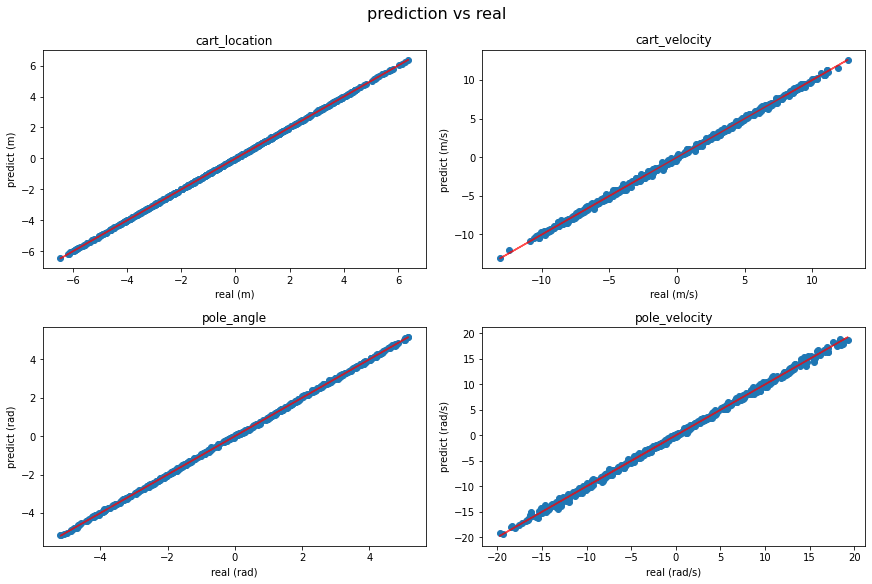

In [60]:
fig, axs = plt.subplots(2,2,figsize=(12,8),constrained_layout=True)

axs[0,0].scatter(Y[:,0]+X[:,0],Y_predict[:,0]+X[:,0])
axs[0,0].plot(Y[:,0]+X[:,0],Y[:,0]+X[:,0],color='r',alpha=0.7)
axs[0,0].set_title('cart_location')
axs[0,0].set_xlabel('real (m)')
axs[0,0].set_ylabel('predict (m)')

axs[0,1].scatter(Y[:,1]+X[:,1],Y_predict[:,1]+X[:,1])
axs[0,1].plot(Y[:,1]+X[:,1],Y[:,1]+X[:,1],color='r',alpha=0.7)
axs[0,1].set_title('cart_velocity')
axs[0,1].set_xlabel('real (m/s)')
axs[0,1].set_ylabel('predict (m/s)')

axs[1,0].scatter(Y[:,2]+X[:,2],Y_predict[:,2]+X[:,2])
axs[1,0].plot(Y[:,2]+X[:,2],Y[:,2]+X[:,2],color='r',alpha=0.7)
axs[1,0].set_title('pole_angle')
axs[1,0].set_xlabel('real (rad)')
axs[1,0].set_ylabel('predict (rad)')

axs[1,1].scatter(Y[:,3]+X[:,3],Y_predict[:,3]+X[:,3])
axs[1,1].plot(Y[:,3]+X[:,3],Y[:,3]+X[:,3],color='r',alpha=0.7)
axs[1,1].set_title('pole_velocity')
axs[1,1].set_xlabel('real (rad/s)')
axs[1,1].set_ylabel('predict (rad/s)')

fig.suptitle('prediction vs real',fontsize=16)
plt.show()

start plotting
(20,)
(20, 4)
(20, 4)


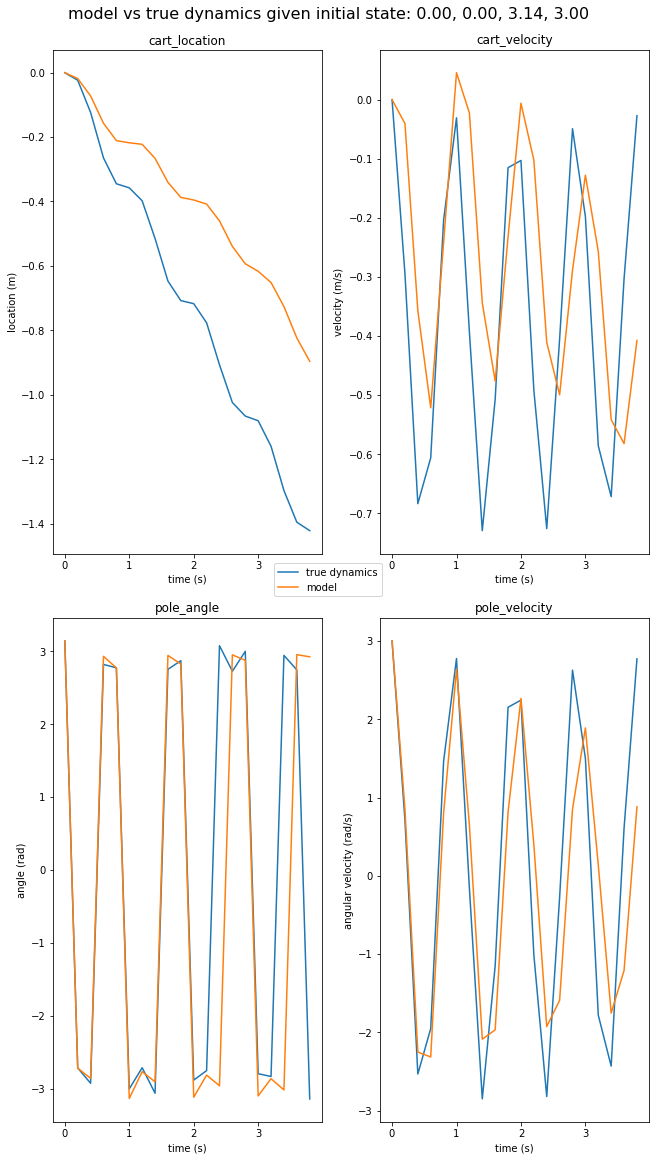

In [83]:
"""time evolution using perfromAction and model"""
# setting parameters
max_t = 4.0
steps = int(max_t/cartpole1.delta_time) # 0.2s per step
Xn = np.array([0,0,np.pi,3])

X_cartpole = [Xn]
X_model = [Xn] 

Xn1_new = Xn
Xn2_new = Xn

for i in range(steps):
    Xn1 = Xn1_new
    Xn2 = Xn2_new
    Xn1 = Xn1.reshape(1,Xn1.shape[0])
    Yn1 = predict(Xn1,XM,sigma,alpha)
    Xn1_new = Xn1 + Yn1
    Xn1_new = np.array(Xn1_new[0])
    Xn1_new[2] = remap_angle(Xn1_new[2])
    X_model.append(Xn1_new)
    cartpole1.setState(Xn2)
    cartpole1.performAction()
    cartpole1.remap_angle()
    Xn2_new = np.array(cartpole1.getState())
    X_cartpole.append(Xn2_new)

X_cartpole = np.array(X_cartpole[:-1])
X_model = np.array(X_model[:-1])


print('start plotting')
"""plotting"""
t = np.arange(0,max_t,cartpole1.delta_time)
fig, axs = plt.subplots(2,2,figsize=(9,16),constrained_layout=True)
print(t.shape)
print(X_cartpole.shape)
print(X_model.shape)
axs[0,0].plot(t,X_cartpole[:,0],label='true dynamic')
axs[0,0].plot(t,X_model[:,0],label='model')
axs[0,0].set_title('cart_location')
axs[0,0].set_xlabel('time (s)')
axs[0,0].set_ylabel('location (m)')
axs[0,0].set_xlim([0,5])
axs[0,0].autoscale()
# axs[0,0].set_ylim([-20,20])

axs[0,1].plot(t,X_cartpole[:,1],label='true dynamics')
axs[0,1].plot(t,X_model[:,1],label='model')
axs[0,1].set_title('cart_velocity')
axs[0,1].set_xlabel('time (s)')
axs[0,1].set_ylabel('velocity (m/s)')
axs[0,1].set_xlim([0,5])
axs[0,1].autoscale()
# axs[0,1].set_ylim([-20,20])

axs[1,0].plot(t,X_cartpole[:,2],label='true dynamics')
axs[1,0].plot(t,X_model[:,2],label='model')
axs[1,0].set_title('pole_angle')
axs[1,0].set_xlabel('time (s)')
axs[1,0].set_ylabel('angle (rad)')
axs[1,0].set_xlim([0,5])
axs[1,0].autoscale()
# axs[1,0].set_ylim([-20,20])

axs[1,1].plot(t,X_cartpole[:,3],label='true dynamics')
axs[1,1].plot(t,X_model[:,3],label='model')
axs[1,1].set_title('pole_velocity')
axs[1,1].set_xlabel('time (s)')
axs[1,1].set_ylabel('angular velocity (rad/s)')
axs[1,1].set_xlim([0,5])
axs[1,1].autoscale()
# axs[1,1].set_ylim([-20,20])


handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
fig.suptitle('model vs true dynamics given initial state: {0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}'.format(
                                                                    Xn[0],Xn[1],Xn[2],Xn[3]), fontsize=16)


plt.savefig('init_state1.png')
plt.show()


start plotting
(20,)
(20, 4)
(20, 4)


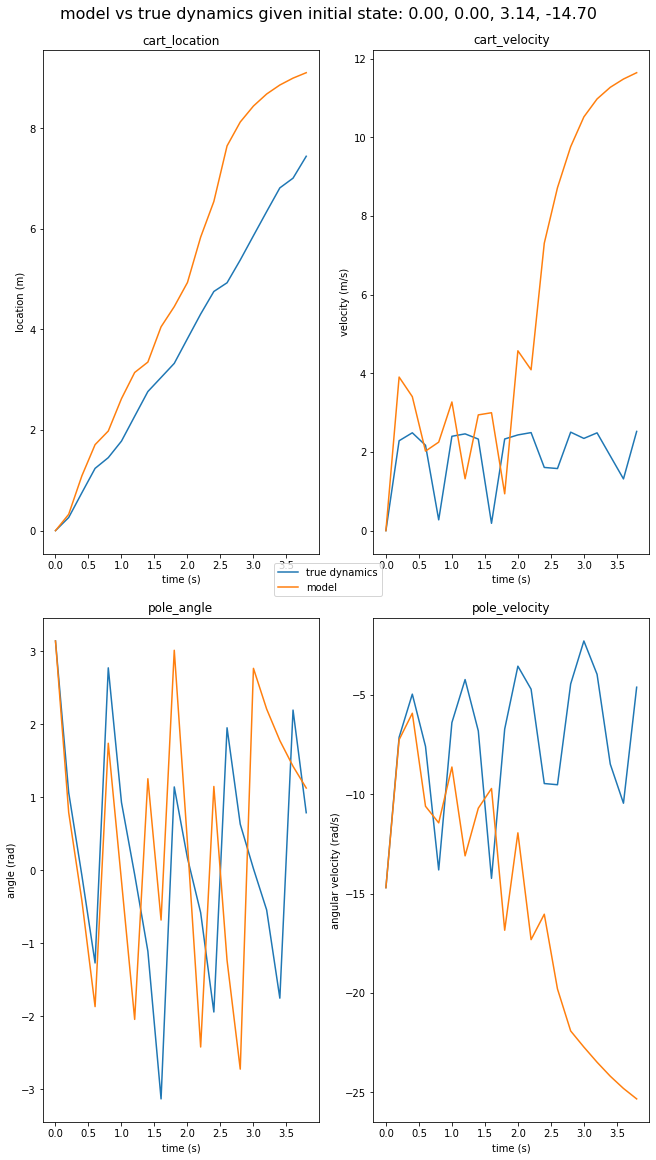

In [85]:
Xn = np.array([0,0,np.pi,-14.7])

X_cartpole = [Xn]
X_model = [Xn] 

Xn1_new = Xn
Xn2_new = Xn

for i in range(steps):
    Xn1 = Xn1_new
    Xn2 = Xn2_new
    Xn1 = Xn1.reshape(1,Xn1.shape[0])
    Yn1 = predict(Xn1,XM,sigma,alpha)
    Xn1_new = Xn1 + Yn1
    Xn1_new = np.array(Xn1_new[0])
    Xn1_new[2] = remap_angle(Xn1_new[2])
    X_model.append(Xn1_new)
    cartpole1.setState(Xn2)
    cartpole1.performAction()
    cartpole1.remap_angle()
    Xn2_new = np.array(cartpole1.getState())
    X_cartpole.append(Xn2_new)

X_cartpole = np.array(X_cartpole[:-1])
X_model = np.array(X_model[:-1])


print('start plotting')
"""plotting"""
t = np.arange(0,max_t,cartpole1.delta_time)
fig, axs = plt.subplots(2,2,figsize=(9,16),constrained_layout=True)
print(t.shape)
print(X_cartpole.shape)
print(X_model.shape)
axs[0,0].plot(t,X_cartpole[:,0],label='true dynamic')
axs[0,0].plot(t,X_model[:,0],label='model')
axs[0,0].set_title('cart_location')
axs[0,0].set_xlabel('time (s)')
axs[0,0].set_ylabel('location (m)')
axs[0,0].set_xlim([0,5])
axs[0,0].autoscale()
# axs[0,0].set_ylim([-20,20])

axs[0,1].plot(t,X_cartpole[:,1],label='true dynamics')
axs[0,1].plot(t,X_model[:,1],label='model')
axs[0,1].set_title('cart_velocity')
axs[0,1].set_xlabel('time (s)')
axs[0,1].set_ylabel('velocity (m/s)')
axs[0,1].set_xlim([0,5])
axs[0,1].autoscale()
# axs[0,1].set_ylim([-20,20])

axs[1,0].plot(t,X_cartpole[:,2],label='true dynamics')
axs[1,0].plot(t,X_model[:,2],label='model')
axs[1,0].set_title('pole_angle')
axs[1,0].set_xlabel('time (s)')
axs[1,0].set_ylabel('angle (rad)')
axs[1,0].set_xlim([0,5])
axs[1,0].autoscale()
# axs[1,0].set_ylim([-20,20])

axs[1,1].plot(t,X_cartpole[:,3],label='true dynamics')
axs[1,1].plot(t,X_model[:,3],label='model')
axs[1,1].set_title('pole_velocity')
axs[1,1].set_xlabel('time (s)')
axs[1,1].set_ylabel('angular velocity (rad/s)')
axs[1,1].set_xlim([0,5])
axs[1,1].autoscale()
# axs[1,1].set_ylim([-20,20])


handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center')
fig.suptitle('model vs true dynamics given initial state: {0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}'.format(
                                                                    Xn[0],Xn[1],Xn[2],Xn[3]), fontsize=16)


plt.savefig('init_state1.png')
plt.show()
